# League of Legends - Tribunal messages potentially banishable

In [198]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")

import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /Users/melvin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/melvin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/melvin/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/melvin/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/melvin/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [199]:
# Lecture des données
df = pd.read_csv('chatlogs.csv')

In [200]:
df.head()

,Unnamed: 0,message,association_to_offender,time,case_total_reports,allied_report_count,enemy_report_count,most_common_report_reason,chatlog_id,champion_name
0,0,gold 2 zed,enemy,00:00:21,8,0,2,Negative Attitude,1,Udyr
1,1,IIII,enemy,00:00:27,8,0,2,Negative Attitude,1,Riven
2,2,nice premade lie :o,enemy,00:00:27,8,0,2,Negative Attitude,1,Udyr
3,3,ISI,enemy,00:00:28,8,0,2,Negative Attitude,1,Riven
4,4,smiteless pls,enemy,00:00:43,8,0,2,Negative Attitude,1,Udyr


In [201]:
# Suppression de certaines catégories de banissement n'étant pas en lien avec le chat du jeu.
# Par exemple, 'Inappropriate Name', est un nom de joueur innaproprié, ce qui n'a pas de lien avec ce que le joueur écrit.
# 'Spamming', peut être un message positif spammé.
# Et 'Assisting Enemy Team', dépend du comportement du joueur dans la partie et non de ses propos.
df.drop( df[ df['most_common_report_reason'] == 'Inappropriate Name' ].index, inplace=True)
df.drop( df[ df['most_common_report_reason'] == 'Spamming' ].index, inplace=True)
df.drop( df[ df['most_common_report_reason'] == 'Assisting Enemy Team' ].index, inplace=True)
# Suppression des messages ennemis et allié qui ne sont pas les messages étant offensant. Les messages offensantes sont ceux de
# l'offender.
df.drop( df[ df['association_to_offender'] == 'enemy' ].index, inplace=True)
df.drop( df[ df['association_to_offender'] == 'ally' ].index, inplace=True)

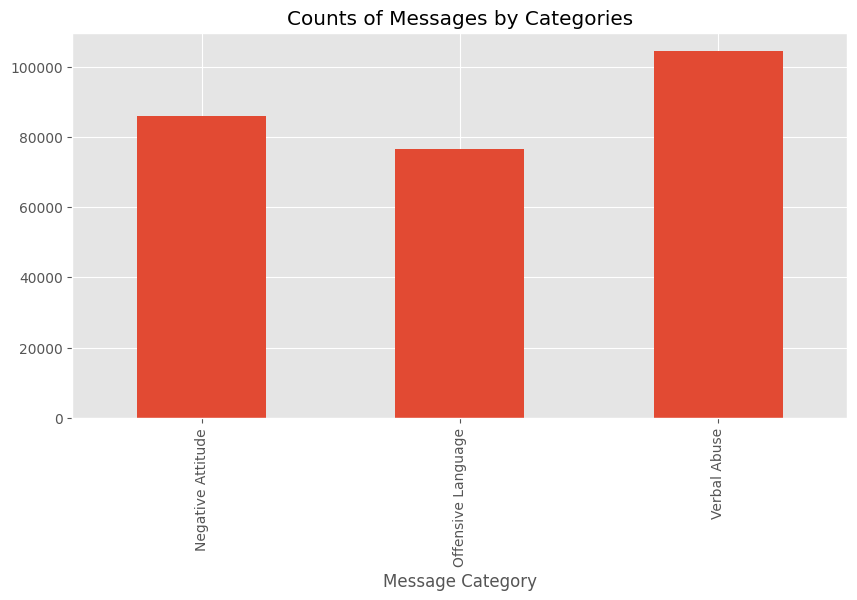

In [202]:
ax = df['most_common_report_reason'].value_counts().sort_index().plot(kind='bar', title='Counts of Messages by Categories',
                                                                 figsize=(10, 5))
ax.set_xlabel('Message Category')
plt.show()

In [203]:
df.shape
df.reset_index(inplace = True, drop = True)
df.index.name = 'Id'
df.insert(0, 'myID', range(0, 0 + len(df)))

In [204]:
example = df['message'][25]
print(example)

go play barbie


In [205]:
tokens = nltk.word_tokenize(example)
tokens

['go', 'play', 'barbie']

In [206]:
tagged = nltk.pos_tag(tokens)
tagged

[('go', 'VB'), ('play', 'NN'), ('barbie', 'NN')]

In [207]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S go/VB play/NN barbie/NN)


In [208]:
# Utilisation de VADER
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

sia = SentimentIntensityAnalyzer()

In [209]:
sia.polarity_scores(example)
df500

,myID,Unnamed: 0,message,association_to_offender,time,case_total_reports,allied_report_count,enemy_report_count,most_common_report_reason,chatlog_id,champion_name
Id,,,,,,,,,,,
0,0,18,bait,offender,00:14:20,8,0,2,Negative Attitude,1,Udyr
1,1,26,Karma reported,offender,00:31:16,8,0,2,Negative Attitude,1,Udyr
2,2,27,Unskilled,offender,00:31:19,8,0,2,Negative Attitude,1,Udyr
3,3,28,No ranked for u my friend,offender,00:31:25,8,0,2,Negative Attitude,1,Udyr
4,4,32,Didnt i say unskilled player?,offender,00:32:06,8,0,2,Negative Attitude,1,Udyr
...,...,...,...,...,...,...,...,...,...,...,...
495,495,2761,ok surrend,offender,00:21:43,4,2,0,Offensive Language,10012,Udyr
496,496,2762,plz,offender,00:21:46,4,2,0,Offensive Language,10012,Udyr
497,497,2765,its over,offender,00:21:48,4,2,0,Offensive Language,10012,Udyr


In [218]:
# Récupérer le score de polarité de chaque message du dataset
res = {}

for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        message = row['message']
        myID = row['myID']
        res[myID] = sia.polarity_scores(message)
    except AttributeError:
        print(f'Broke for id {myID}')
    

  0%|          | 0/267022 [00:00<?, ?it/s]

Broke for id 14629
Broke for id 116544
Broke for id 151250
Broke for id 244481
Broke for id 246108
Broke for id 246113


In [222]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'myID'})
vaders = vaders.merge(df, how='left')

In [224]:
vaders.head()

,myID,neg,neu,pos,compound,Unnamed: 0,message,association_to_offender,time,case_total_reports,allied_report_count,enemy_report_count,most_common_report_reason,chatlog_id,champion_name
0,0,0.000,1.000,0.000,0.00,18,bait,offender,00:14:20,8,0,2,Negative Attitude,1,Udyr
1,1,0.000,1.000,0.000,0.00,26,Karma reported,offender,00:31:16,8,0,2,Negative Attitude,1,Udyr
2,2,0.000,1.000,0.000,0.00,27,Unskilled,offender,00:31:19,8,0,2,Negative Attitude,1,Udyr
3,3,0.262,0.357,0.381,0.25,28,No ranked for u my friend,offender,00:31:25,8,0,2,Negative Attitude,1,Udyr
4,4,0.000,1.000,0.000,0.00,32,Didnt i say unskilled player?,offender,00:32:06,8,0,2,Negative Attitude,1,Udyr


Text(0.5, 1.0, 'Compound score by Report Category')

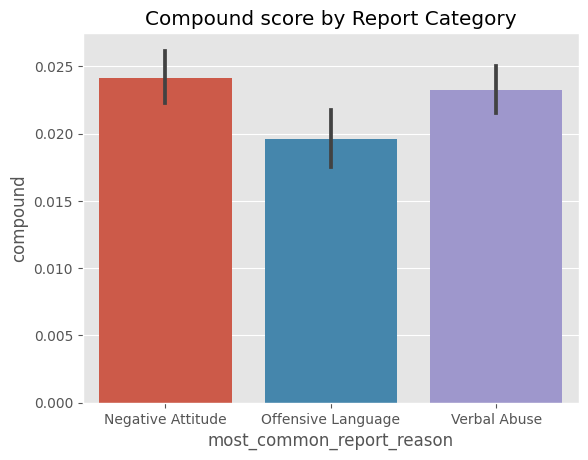

In [227]:
ax = sns.barplot(data=vaders, x='most_common_report_reason', y='compound')
ax.set_title('Compound score by Report Category')

<AxesSubplot: xlabel='most_common_report_reason', ylabel='pos'>

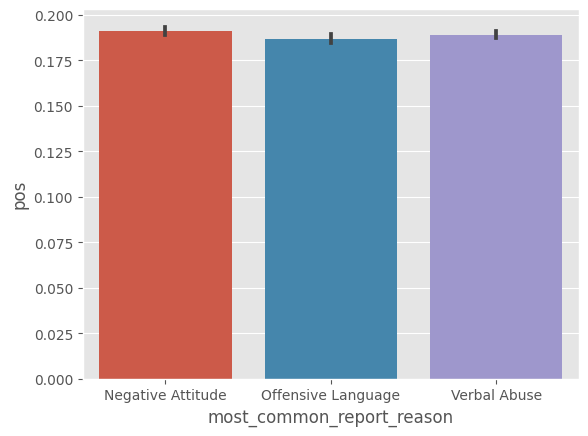

In [228]:
sns.barplot(data=vaders, x='most_common_report_reason', y='pos')

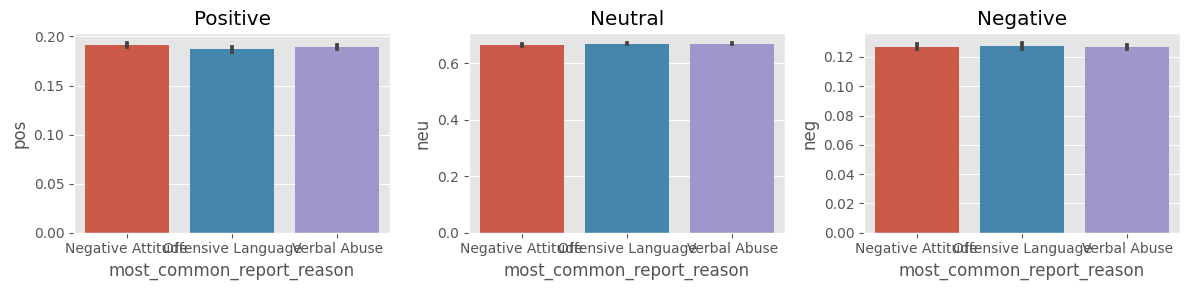

In [229]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='most_common_report_reason', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='most_common_report_reason', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='most_common_report_reason', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [234]:
len(vaders[vaders['pos']>0])

74093

In [235]:
len(vaders[vaders['neg']>0])

57271

In [236]:
len(vaders[vaders['neu']>0])

225465

In [240]:
vaders[vaders['pos']>0]

,myID,neg,neu,pos,compound,Unnamed: 0,message,association_to_offender,time,case_total_reports,allied_report_count,enemy_report_count,most_common_report_reason,chatlog_id,champion_name
3,3,0.262,0.357,0.381,0.2500,28,No ranked for u my friend,offender,00:31:25,8,0,2,Negative Attitude,1,Udyr
5,5,0.000,0.000,1.000,0.2960,52,gg,offender,00:59:25,8,0,2,Negative Attitude,1,Udyr
12,12,0.000,0.000,1.000,0.3182,107,sure,offender,00:10:10,2,1,0,Offensive Language,10,Lux
25,25,0.000,0.455,0.545,0.3400,252,go play barbie,offender,00:27:45,2,1,0,Offensive Language,10,Lux
33,33,0.000,0.000,1.000,0.2960,374,gg,offender,00:08:01,4,2,0,Negative Attitude,1000,Xin Zhao
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267004,267010,0.000,0.526,0.474,0.2023,1697099,SHACO GANK TOP,offender,00:12:21,10,0,3,Offensive Language,9999,Kassadin
267011,267017,0.000,0.794,0.206,0.0772,1697146,REPORT MY TEAM PLS NOOBS 4-EVER,offender,00:16:20,10,0,3,Offensive Language,9999,Kassadin
267012,267018,0.000,0.000,1.000,0.4019,1697150,yes,offender,00:17:45,10,0,3,Offensive Language,9999,Kassadin
267014,267020,0.000,0.000,1.000,0.4588,1697215,yes pls,offender,00:28:21,10,0,3,Offensive Language,9999,Kassadin


# Utilisation de Roberta

In [247]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [248]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [250]:
# VADER Score pour example
print(example)
sia.polarity_scores(example)

go play barbie


{'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'compound': 0.34}

In [255]:
# Roberta
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
}
print(scores_dict)

{'roberta_neg': 0.055187948, 'roberta_neu': 0.731257, 'roberta_pos': 0.21355507}


In [256]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg' : scores[0],
        'roberta_neu' : scores[1],
        'roberta_pos' : scores[2]
    }
    return scores_dict

In [265]:
res = {}

for i, row in tqdm(df500.iterrows(), total=len(df500)):
    try:
        message = row['message']
        myID = row['myID']
        vader_res = sia.polarity_scores(message)
        vader_res_rename = {}
        for key, value in vader_res.items():
            vader_res_rename[f"vader_{key}"] = value
        
        roberta_res = polarity_scores_roberta(message)
        
        both = {**vader_res_rename, **roberta_res}
        res[myID] = both
        
    except RuntimeError:
        print(f'Broke for id {myID}')
        
    except AttributeError:
        print(f'Broke for id {myID}')

  0%|          | 0/500 [00:00<?, ?it/s]

In [266]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'myID'})
results_df = results_df.merge(df, how='left')

In [272]:
results_df.columns

Index(['myID', 'vader_neg', 'vader_neu', 'vader_pos', 'vader_compound',
       'roberta_neg', 'roberta_neu', 'roberta_pos', 'Unnamed: 0', 'message',
       'association_to_offender', 'time', 'case_total_reports',
       'allied_report_count', 'enemy_report_count',
       'most_common_report_reason', 'chatlog_id', 'champion_name'],
      dtype='object')

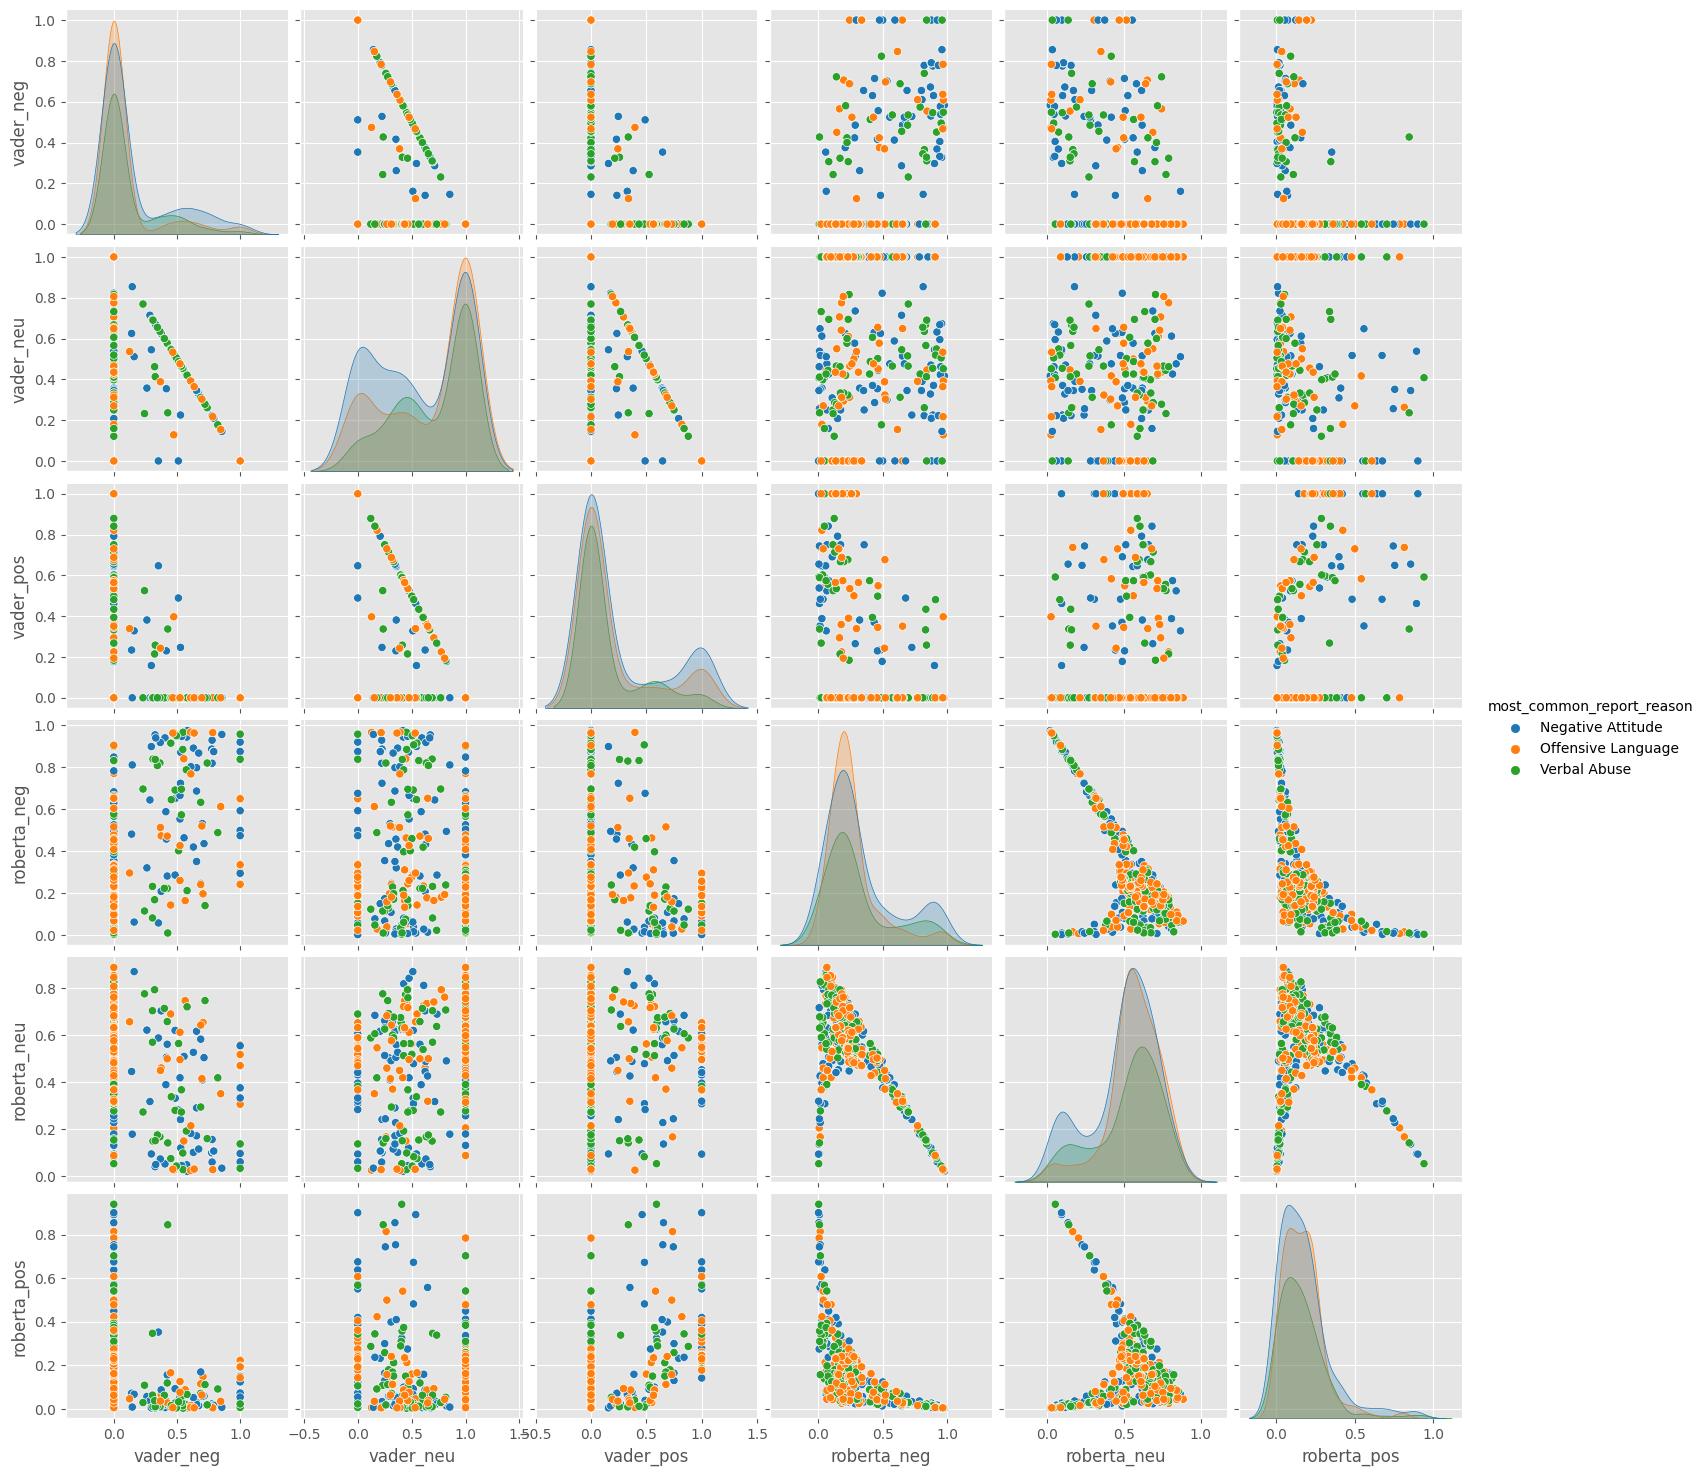

In [273]:
sns.pairplot(data=results_df,
             vars=['vader_neg', 'vader_neu', 'vader_pos',
                  'roberta_neg', 'roberta_neu', 'roberta_pos'],
            hue='most_common_report_reason',
            palette='tab10')
plt.show()

In [275]:
from transformers import pipeline

sent_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

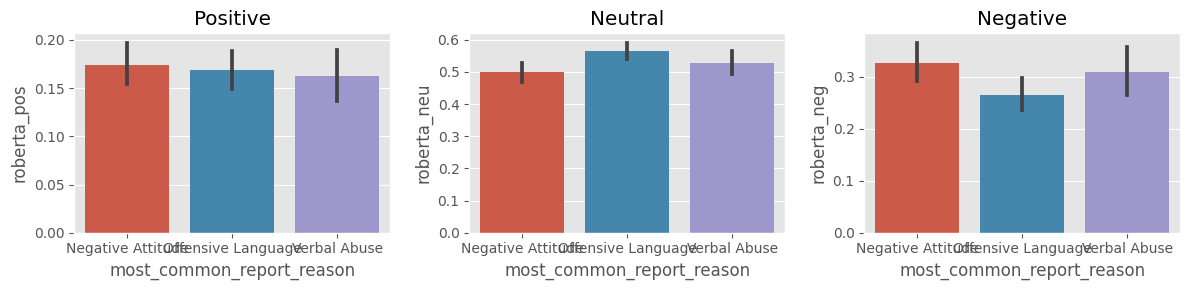

In [286]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=results_df, x='most_common_report_reason', y='roberta_pos', ax=axs[0])
sns.barplot(data=results_df, x='most_common_report_reason', y='roberta_neu', ax=axs[1])
sns.barplot(data=results_df, x='most_common_report_reason', y='roberta_neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [307]:
len(results_df[results_df['roberta_neg']>0.2])

297

In [292]:
results_df[results_df['roberta_neg']>0]

,myID,vader_neg,vader_neu,vader_pos,vader_compound,roberta_neg,roberta_neu,roberta_pos,Unnamed: 0,message,association_to_offender,time,case_total_reports,allied_report_count,enemy_report_count,most_common_report_reason,chatlog_id,champion_name
0,0,0.000,1.000,0.000,0.0000,0.311527,0.532403,0.156070,18,bait,offender,00:14:20,8,0,2,Negative Attitude,1,Udyr
1,1,0.000,1.000,0.000,0.0000,0.449940,0.526569,0.023491,26,Karma reported,offender,00:31:16,8,0,2,Negative Attitude,1,Udyr
2,2,0.000,1.000,0.000,0.0000,0.526619,0.436611,0.036771,27,Unskilled,offender,00:31:19,8,0,2,Negative Attitude,1,Udyr
3,3,0.262,0.357,0.381,0.2500,0.321523,0.621264,0.057213,28,No ranked for u my friend,offender,00:31:25,8,0,2,Negative Attitude,1,Udyr
4,4,0.000,1.000,0.000,0.0000,0.496821,0.486879,0.016301,32,Didnt i say unskilled player?,offender,00:32:06,8,0,2,Negative Attitude,1,Udyr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,0.000,0.312,0.688,0.2960,0.182536,0.576327,0.241137,2761,ok surrend,offender,00:21:43,4,2,0,Offensive Language,10012,Udyr
496,496,0.000,0.000,1.000,0.0772,0.137642,0.631978,0.230380,2762,plz,offender,00:21:46,4,2,0,Offensive Language,10012,Udyr
497,497,0.000,1.000,0.000,0.0000,0.409414,0.428250,0.162336,2765,its over,offender,00:21:48,4,2,0,Offensive Language,10012,Udyr
498,498,0.636,0.364,0.000,-0.5423,0.963820,0.031269,0.004911,2773,they fuck us,offender,00:22:15,4,2,0,Offensive Language,10012,Udyr


In [345]:
input_results = sent_pipeline('i missed my train')
print(input_results)
if input_results[0]['label']=='NEGATIVE' and input_results[0]['score']>0.50 :
    print('This message is potentially banishable.')
else:
    print('This message is not potentially banishable.')

[{'label': 'NEGATIVE', 'score': 0.999701201915741}]
This message is potentially banishable.
